In [64]:
from tensorflow.keras.models import load_model
model = load_model(r"C:\Users\RITIKA\Desktop\2nd year\sem 4\Sodoku project\SudokuModel.h5")


In [65]:
def preProcess(img):
    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # CONVERT IMAGE TO GRAY SCALE
    imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 1)  # ADD GAUSSIAN BLUR
    imgThreshold = cv2.adaptiveThreshold(imgBlur, 255, 1, 1, 11, 2)  # APPLY ADAPTIVE THRESHOLD
    return imgThreshold

In [66]:
def reorder(myPoints):
    myPoints = myPoints.reshape((4, 2))
    myPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
    add = myPoints.sum(1)
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] =myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] =myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    return myPointsNew

In [67]:
def biggestContour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest,max_area

In [68]:
def splitBoxes(img):
    rows = np.vsplit(img,9)
    boxes=[]
    for r in rows:
        cols= np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes

In [69]:
def digitdetection(boxes, model):
    result = []
    for image in boxes:
        #preprocessing
        img = np.asarray(image)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] -4]
        img = cv2.resize(img, (32, 32))  # Resize the image to (32, 32)
        img = img / 255
        img = img.reshape(1, 32, 32, 1)
        predictions = model.predict(img)
        classIndex = np.argmax(predictions)  # Use np.argmax() instead of model.predict_classes()
        probabilityValue = np.amax(predictions)
        if probabilityValue<0.4:
            result.append(0)
        else:
            result.append(classIndex)
    return result


In [70]:
def displayNumbers(img,numbers,color = (0,255,0)):
    secW = int(img.shape[1]/9)
    secH = int(img.shape[0]/9)
    for x in range (0,9):
        for y in range (0,9):
            if numbers[(y*9)+x] != 0 :
                cv2.putText(img, str(numbers[(y*9)+x]),(x*secW+int(secW/2)-10, int((y+0.8)*secH)), cv2.FONT_HERSHEY_COMPLEX_SMALL,2, color, 2, cv2.LINE_AA)
    return img

In [71]:
def drawGrid(img):
    secW = int(img.shape[1]/9)
    secH = int(img.shape[0]/9)
    for i in range (0,9):
        pt1 = (0,secH*i)
        pt2 = (img.shape[1],secH*i)
        pt3 = (secW * i, 0)
        pt4 = (secW*i,img.shape[0])
        cv2.line(img, pt1, pt2, (255, 255, 0),2)
        cv2.line(img, pt3, pt4, (255, 255, 0),2)
    return img

In [72]:
def stackImages(imgArray,scale):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range ( 0, rows):
            for y in range(0, cols):
                imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y]= cv2.cvtColor( imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
            hor_con[x] = np.concatenate(imgArray[x])
        ver = np.vstack(hor)
        ver_con = np.concatenate(hor)
    else:
        for x in range(0, rows):
            imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor= np.hstack(imgArray)
        hor_con= np.concatenate(imgArray)
        ver = hor
    return ver

In [73]:
def solve(matrix):
    M = 9
    solved=[]
    def puzzle(a):
        for i in range(M):
            row=[]
            for j in range(M):
                row.append(a[i][j])
            solved.append(row)    
    def solve(grid, row, col, num):
        for x in range(9):
            if grid[row][x] == num:
                return False
        for x in range(9):
            if grid[x][col] == num:
                return False
        startRow = row - row % 3
        startCol = col - col % 3
        for i in range(3):
            for j in range(3):
                if grid[i + startRow][j + startCol] == num:
                    return False
        return True
    def Suduko(grid, row, col):
        if (row == M - 1 and col == M):
            return True
        if col == M:
            row += 1
            col = 0
        if grid[row][col] > 0:
            return Suduko(grid, row, col + 1)
        for num in range(1, M + 1, 1): 
            if solve(grid, row, col, num):
                grid[row][col] = num
                if Suduko(grid, row, col + 1):
                    return True
                grid[row][col] = 0
        return False
    '''0 means the cells where no value is assigned'''
    if (Suduko(matrix, 0, 0)):
        puzzle(matrix)
    return solved

In [74]:
def sudoku(path):
    heightImg = 450
    widthImg = 450
    img = cv2.imread(path)
    img = cv2.resize(img, (widthImg, heightImg))  # RESIZE IMAGE TO MAKE IT A SQUARE IMAGE
    imgBlank = np.zeros((heightImg, widthImg, 3), np.uint8)  # CREATE A BLANK IMAGE FOR TESTING DEBUGING IF REQUIRED
    imgThreshold = preProcess(img)
    imgContours = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
    imgBigContour = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
    contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # FIND ALL CONTOURS
    cv2.drawContours(imgContours, contours, -1, (0, 255, 0), 3) # DRAW ALL DETECTED CONTOURS
    biggest, maxArea = biggestContour(contours) # FIND THE BIGGEST CONTOUR
    #print(biggest)
    if biggest.size != 0:
        biggest = reorder(biggest)
        #print(biggest)
        cv2.drawContours(imgBigContour, biggest, -1, (0, 0, 255), 25) # DRAW THE BIGGEST CONTOUR
        pts1 = np.float32(biggest) # PREPARE POINTS FOR WARP
        pts2 = np.float32([[0, 0],[widthImg, 0], [0, heightImg],[widthImg, heightImg]]) # PREPARE POINTS FOR WARP
        matrix = cv2.getPerspectiveTransform(pts1, pts2) # GER
        imgWarpColored = cv2.warpPerspective(img, matrix, (widthImg, heightImg))
        imgDetectedDigits = imgBlank.copy()
        imgWarpColored = cv2.cvtColor(imgWarpColored,cv2.COLOR_BGR2GRAY)

        imgSolvedDigits = imgBlank.copy()
        boxes = splitBoxes(imgWarpColored)
        #print(len(boxes))
        numbers =digitdetection(boxes, model)
        #print(numbers)
        imgDetectedDigits = displayNumbers(imgDetectedDigits, numbers, color=(255, 0, 255))
        numbers = np.asarray(numbers)
        posArray = np.where(numbers > 0, 0, 1)
        #print(posArray)


        board = np.array_split(numbers,9)
        print(board)
        try:
            solved=solve(board)
        except:
            pass
        print(solved)
        flatList = []
        for sublist in solved:
            for item in sublist:
                flatList.append(item)
        solvedNumbers =flatList*posArray
        imgSolvedDigits= displayNumbers(imgSolvedDigits,solvedNumbers)

        # #### 6. OVERLAY SOLUTION
        pts2 = np.float32(biggest) # PREPARE POINTS FOR WARP
        pts1 =  np.float32([[0, 0],[widthImg, 0], [0, heightImg],[widthImg, heightImg]]) # PREPARE POINTS FOR WARP
        matrix = cv2.getPerspectiveTransform(pts1, pts2)  # GER
        imgInvWarpColored = img.copy()
        imgInvWarpColored = cv2.warpPerspective(imgSolvedDigits, matrix, (widthImg, heightImg))
        inv_perspective = cv2.addWeighted(imgInvWarpColored, 1, img, 0.5, 1)
        imgDetectedDigits = drawGrid(imgDetectedDigits)
        imgSolvedDigits = drawGrid(imgSolvedDigits)

        imageArray = ([img,imgThreshold,imgContours, imgBigContour],[imgWarpColored,imgDetectedDigits, imgSolvedDigits,inv_perspective])
        stackedImage = stackImages(imageArray, 1)
        plt.figure(figsize=(10, 8)) 
        plt.imshow(stackedImage)

    else:
        print("No Sudoku Found")

    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

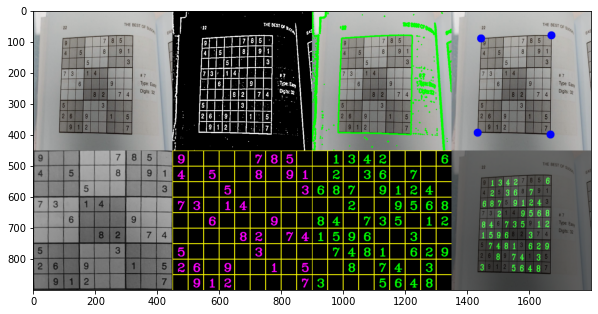

In [75]:
sudoku("image1.jpeg")